# MNIST

In [1]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata("MNIST original", data_home="mldata.org")
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [2]:
from sklearn.datasets.base import get_data_home

print (get_data_home())

/home/vagrant/scikit_learn_data


In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


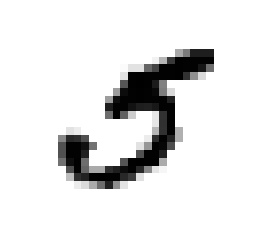

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [5]:
y[36000]

5.0

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# 二項分類器の訓練

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, max_iter=100)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=100, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

# 性能指標

## 交差検証を使った正解率の測定

In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.94955, 0.9638 , 0.96365])

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91105, 0.90895, 0.90895])

## 混同行列

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([False,  True, False, ..., False, False, False])

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53143,  1436],
       [ 1024,  4397]])

## 適合率と再現率

In [16]:
from sklearn.metrics import precision_score

precision_score(y_train_5, y_train_pred)

0.753814503685925

In [17]:
from sklearn.metrics import recall_score

recall_score(y_train_5, y_train_pred)

0.8111049621840989

In [18]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.781411053847521

## 適合率と再現率のトレードオフ

In [19]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([3335.85925237])

In [20]:
threshold = 0
y_some_digit_pred = (y_scores >  threshold)
y_some_digit_pred

array([ True])

In [21]:
threshold = 2000
y_some_digit_pred = (y_scores >  threshold)
y_some_digit_pred

array([ True])

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [23]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

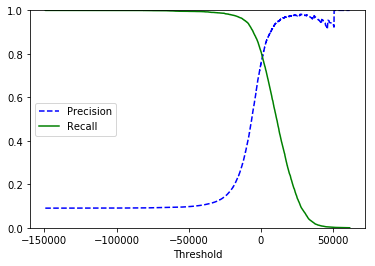

In [24]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[: -1], "b--", label="Precision")
    plt.plot(thresholds, recalls[: -1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

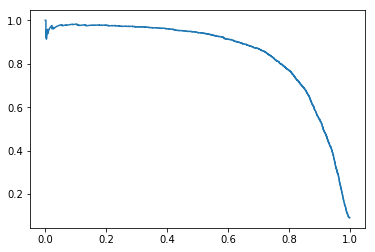

In [25]:
plt.plot(recalls[:-1], precisions[:-1])
plt.show()

In [26]:
y_train_pred_90 = (y_scores > 9000)

precision_score(y_train_5, y_train_pred_90)

0.9290322580645162

In [27]:
recall_score(y_train_5, y_train_pred_90)

0.557830658550083

## ROC曲線

In [28]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

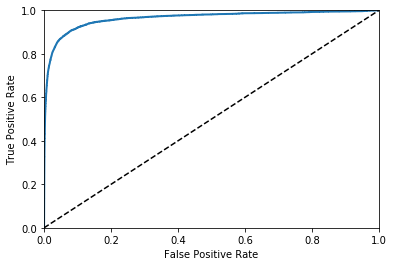

In [29]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
plot_roc_curve(fpr, tpr)
plt.show()

In [30]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9638511871246653

In [31]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [32]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

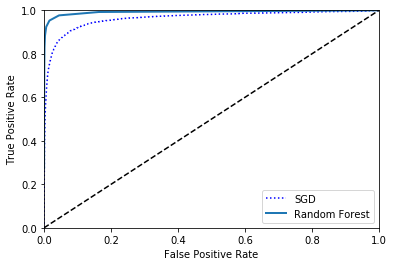

In [33]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [34]:
roc_auc_score(y_train_5, y_scores_forest)

0.9924726392266482

## 他クラス分類

In [35]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5.])

In [36]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-10778.83541314, -27998.40523402, -18515.78607002,
         -3763.90980965, -21410.69487827,   3335.85925237,
        -46272.53020841, -24717.03026795, -26110.41516647,
        -35511.01139585]])

In [37]:
np.argmax(some_digit_scores)

5

In [38]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [39]:
sgd_clf.classes_[5]

5.0

In [40]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [41]:
len(ovo_clf.estimators_)

45

In [42]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

In [43]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0.1, 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [44]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.86922615, 0.8659433 , 0.88363254])

In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91096781, 0.91229561, 0.91273691])

## 誤分類の分析

In [46]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5703,    1,   17,    9,   11,   49,   43,    7,   79,    4],
       [   1, 6459,   48,   25,    6,   48,    5,    8,  128,   14],
       [  46,   30, 5331,  104,   77,   29,   75,   49,  205,   12],
       [  34,   32,  133, 5357,    2,  227,   30,   53,  177,   86],
       [  14,   16,   44,   11, 5346,    9,   52,   28,  127,  195],
       [  52,   30,   31,  181,   61, 4616,   91,   22,  246,   91],
       [  31,   22,   42,    2,   41,   92, 5610,    8,   69,    1],
       [  22,   15,   71,   32,   56,   10,    4, 5775,   39,  241],
       [  29,   87,   57,  132,    8,  145,   45,   15, 5246,   87],
       [  33,   26,   30,   84,  139,   39,    2,  182,  137, 5277]])

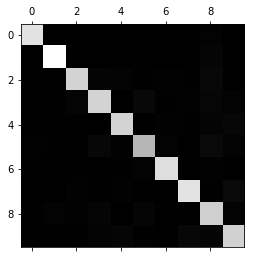

In [47]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

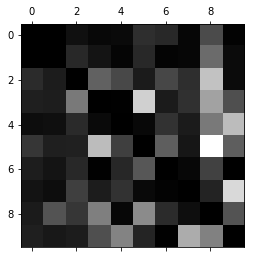

In [48]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

## 多ラベル分類

In [49]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [50]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
y_train_knn_pred = cross_val_score(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_trian_knn_pred, average="macro")

## 多出力分類

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test